# Обучение, переобучение, недообучение и кросвалидация

In [2]:
import pandas as pd
from sklearn import tree
import seaborn as sns
from sklearn.model_selection import train_test_split

titanic_data = pd.read_csv('data/titanic/train.csv')
#titanic_data.info()

# для обучения, удалим некотрые переменные из датасета
drop_col = [
  'PassengerId', # бесполезное
  'Survived', # убираем т.к. будем ее предсказывать
  'Name', # бесполезно т.к. это можно сказаь уникальное для пассажира, не имет смысла использовать для выявления какой-то закономерности
  'Ticket', # убираем, т.к. это просто строковый ид-тор
  'Cabin' # убираем из-за большого кол-ва пропусков
]

X = titanic_data.drop(drop_col, axis=1) # фичи
y = titanic_data['Survived'] # будем предсказывать

# необходимо конвертировать строковые переменные в числовые для дерева
# get_dummies - не трогает переменные которые записаны в числовом виде, но при этом другие менят на 0 или 1
X = pd.get_dummies(X)

# заполним пропущенные значения для age
# возьмем медиану, Можно было обучить модель для предсказания возраста, но пока возьмем по простому
# или можно взять медиану для м и ж отдельно
X = X.fillna({'Age': X['Age'].median()})



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# дерево решений
# ограничим уровень роста до 5
#cls = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

#learn_tree = cls.fit(X, y)
#tree.plot_tree(learn_tree, filled=True, class_names=['Died', 'Survived'], feature_names=list(X))

<Axes: xlabel='max_depth', ylabel='score'>

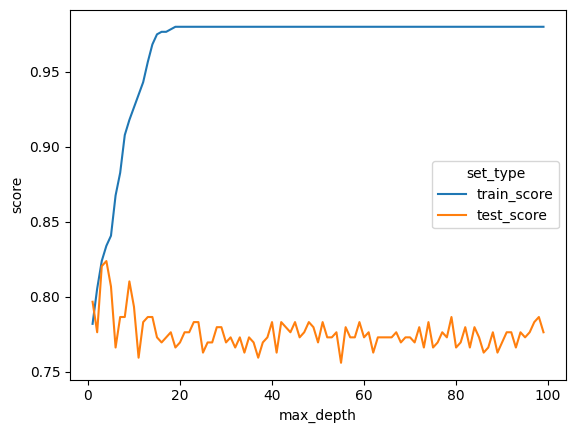

In [3]:
# диапазон глубины дерева
# начало с 1
max_depth_value = range(1, 100)

scores_data_list = []

for max_depth in max_depth_value:
  clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
  clf.fit(X_train, y_train)
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)

  temp_score_data = pd.DataFrame({
    'max_depth': [max_depth], 
    'train_score': [train_score], 
    'test_score': [test_score ]
  })

  scores_data_list.append(temp_score_data)

scores_data = pd.concat(scores_data_list, ignore_index=True)

# возможно в таком виде будет удобнее
# ----------------------------
# | max_depth|set_type|score |
# ----------------------------
# id_vars - отвечает за группировку
# value_vars - те переменные значения которых мы хотим использовать для score
# var_name - название колонки типа ключа
# value_name - название колонки значении
scores_data_meld = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'], var_name='set_type', value_name='score')


# нарисуем график
sns.lineplot(x = 'max_depth', y = 'score', hue='set_type', data=scores_data_meld)

Описание графика: с увелечением кол-во глубины дерева, тем точнее мы классифициюем наблюдения тот датасет на которму обучалясь, чем глубже даем дереву расти тем лучше ему удается классифицировать данные. Другие дело, что эти данные при обобщении, при вычленении некоторой закономерности, не всегда явл. наиболее хорошем описанием той закономерности которую мы иследуем. 

А что у нас происходит с test_score: вначе test_score низкий, например когда глубина = 1, 2 - это означает, что модель еще недоучилась. Дальше вместе с увелечением train_score, test_score начинает постепенно снижаться, т.е. мы от недообученности модели пришли к некотому оптимальному состоянию, а дальнейшее углубленее дерева приводит к тому, что мы начинаем переобучаться и вместо того, чтоб применить мин. усилии при этому получить макс информации - пускаемся во все тяжкие, впадаем в переобучение.

## Шаг 6, задание
Отметьте верные утверждения об обучении моделей
![image](image/2_4_6.jpg)

## Шаг 10
Проблема с которой мы столкнулись было в том, что мы переобучили модель. Мы один раз разфитили данные на train и test и дальше никогда не меняли это соотношение и каждый раз тестировали нашу модель на одном и том же датасете (test_data). Эта проблема хорошо описана в док-ции sklearn, где и предлагаются разные способы более правильному обучению модели. Кроссвалидация одна из самых простых способов

In [6]:
from sklearn.model_selection import cross_val_score

cls_cross = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

# cv = 5, разбиваем на 5 folds 
# посмотрим на точной которую покажет классификатор при кроссвалидации
cross_val_score_arr = cross_val_score(cls_cross, X_train, y_train, cv=5)
cross_val_score_arr

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [7]:
# среднее значение
cross_val_score_arr.mean()

0.7886274509803922

результат в массиве читается с нулевого индекса, но при этом в таблице с конца.

0.76666667 - вначале мы обучились на первых четырех фолдах, а на пятом протестировали

0.82342941 - обучились на первыйх трех и пятом, а протестили на четвертом

и т.д.

Переобучим заново с использованием кроссвалидации:

<Axes: xlabel='max_depth', ylabel='score'>

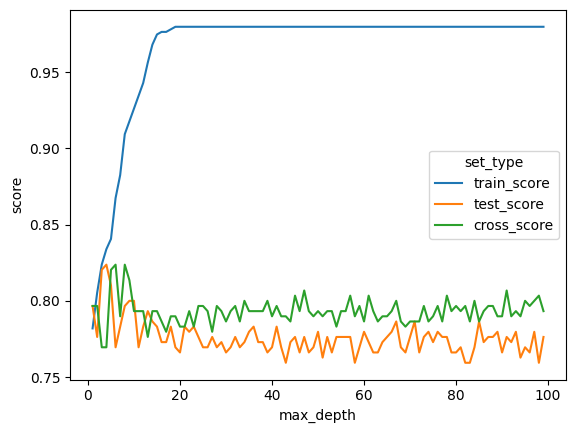

In [9]:
scores_data_list = []

for max_depth in max_depth_value:
  clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
  clf.fit(X_train, y_train)
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  cross_score = cross_val_score(clf, X_test, y_test, cv=5).mean()
 
  temp_score_data = pd.DataFrame({
    'max_depth': [max_depth], 
    'train_score': [train_score], 
    'test_score': [test_score ],
    'cross_score': [cross_score]
  })

  scores_data_list.append(temp_score_data)

scores_data = pd.concat(scores_data_list, ignore_index=True)

# возможно в таком виде будет удобнее
# ----------------------------
# | max_depth|set_type|score |
# ----------------------------
# id_vars - отвечает за группировку
# value_vars - те переменные значения которых мы хотим использовать для score
# var_name - название колонки типа ключа
# value_name - название колонки значении
scores_data_meld = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_score'], var_name='set_type', value_name='score')


# нарисуем график
sns.lineplot(x = 'max_depth', y = 'score', hue='set_type', data=scores_data_meld)

In [17]:
scores_data_meld.query('set_type == "cross_score"').head(5).sort_values(by='score', ascending=False)

,max_depth,set_type,score
202,5,cross_score,0.820339
198,1,cross_score,0.796610
199,2,cross_score,0.796610
200,3,cross_score,0.769492
201,4,cross_score,0.769492


видно, что при глубине 5 достигается макс score (точность)

Теперь протестим тестовые данные на best классификаторе с найденной лучшей глубиной дерева

In [21]:
cls_best = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)


cls_best.fit(X_train, y_train)
cls_best.score(X_test, y_test)
# cv = 5, разбиваем на 5 folds 
# посмотрим на точной которую покажет классификатор при кроссвалидации
#cross_val_score_arr = cross_val_score(cls_best, X_test, y_test, cv=5)
#cross_val_score_arr.mean()

0.8067796610169492